In [22]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone, BaseEstimator, TransformerMixin, ClassifierMixin
import matplotlib.pyplot as plt
%matplotlib inline

## bagging

In [6]:
sample = np.random.randint( 1, 100, size=10 )
print('Original sample: ', sample )
print("Sample mean: ", sample.mean() )
resamples = [np.random.choice( sample, size=sample.shape ) for i in range(100) ]
# list, 里面有100个array数据，每个数据中有10个数字, 每个数字都是随机从sample中抽选出来的
print("Number of bootstrap re-samples: ", len(resamples) )
print('Example re-sample: ', resamples[0] )
resample_means = np.array([ resample.mean() for resample in resamples ])
print('Mean of re-samples\'s means: ', resample_means.mean() )
# 对比样本的平均值和重抽样之后的平均值

Original sample:  [48 66 84 65 65 65 89 89 83 83]
Sample mean:  73.7
Number of bootstrap re-samples:  100
Example re-sample:  [65 65 89 65 83 65 48 83 65 83]
Mean of re-samples's means:  74.047


In [10]:
x, y = make_classification(n_samples=1000, n_features=100, 
                           n_informative=20, n_clusters_per_class=2,
                           random_state = 11 )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11 )
clf = DecisionTreeClassifier( random_state=11 )
clf.fit( x_train, y_train )
predictions = clf.predict( x_test)
print( classification_report(y_test, predictions) )

             precision    recall  f1-score   support

          0       0.73      0.66      0.69       127
          1       0.68      0.75      0.71       123

avg / total       0.71      0.70      0.70       250



In [13]:
rfc = RandomForestClassifier( n_estimators=10, random_state=11 )
rfc.fit(x_train, y_train )
predictions = rfc.predict(x_test)
print(classification_report(y_test, predictions) )

             precision    recall  f1-score   support

          0       0.74      0.83      0.79       127
          1       0.80      0.70      0.75       123

avg / total       0.77      0.77      0.77       250



## Boosting

In [16]:
x, y = make_classification( n_samples=1000, n_features=50, 
                           n_informative=30, n_clusters_per_class=3,
                          random_state=11 )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11 )
dtc = DecisionTreeClassifier( random_state=11 )
dtc.fit( x_train, y_train )
print('Decision tree accuracy: ', dtc.score(x_test, y_test) )

Decision tree accuracy:  0.688


In [17]:
adabc = AdaBoostClassifier( n_estimators=50, random_state=11 )
adabc.fit( x_train, y_train )

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=11)

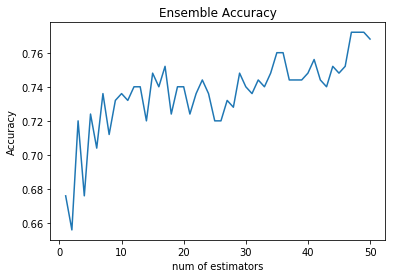

In [21]:
plt.xlabel('num of estimators')
plt.ylabel('Accuracy')
plt.title('Ensemble Accuracy')
plt.plot( range(1,51), list(adabc.staged_score( x_test, y_test) ))
# 从下图可以看出，随着预测器数量的增加，集成学习器的表现越来越好

## Stacking

In [23]:
class StackingClassifier( BaseEstimator, ClassifierMixin, TransformerMixin ):
    
    def __init__( self, classifiers ):
        self.classifiers = classifiers
        self.meta_classifier = DecisionTreeClassifier()
    
    def fit(self, x, y ):
        for clf in self.classifiers:
            clf.fit(x, y)
        self.meta_classifier.fit( self._get_meta_features(x), y)
        return self
    
    def _get_meta_features( self, x):
        probas = np.asarray([ clf.predict_proba(x) for clf in 
                             self.classifiers ])
        return np.concatenate( probas, axis=1 )
    
    def predict( self, x):
        return self.meta_classifier.predict(self._get_meta_features(x) )
    
    
x, y = make_classification(n_samples = 1000, n_features = 50,
                           n_informative = 30, n_clusters_per_class = 3,
                           random_state = 11 )
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11 )
lgr = LogisticRegression()
lgr.fit( x_train, y_train )
print('Logistic regression accuracy: ', lgr.score(x_test, y_test ) )
knnc = KNeighborsClassifier()
knnc.fit(x_train, y_train )
print('KNN accuracy: ', knnc.score(x_test, y_test) )

base_classifiers = [lgr, knnc]
stacking_clf = StackingClassifier( base_classifiers )
stacking_clf.fit(x_train, y_train )
print('Stacking claffifier accuracy: ', stacking_clf.score(x_test, y_test))
# 同样的两个模型集成起来就比单独的好

Logistic regression accuracy:  0.816
KNN accuracy:  0.836
Stacking claffifier accuracy:  0.852
